In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

# Data 

In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

/home/thor_01/miniconda3/envs/ds2023/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

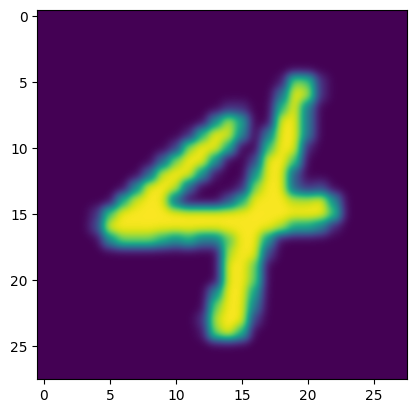

In [4]:

plt.imshow(X_train[0].reshape(28, 28), interpolation="gaussian")

In [5]:
X_train[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best score for RandomForestClassifier: 0.9672833333333334
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters for ExtraTreesClassifier: {'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 200}
Best score for ExtraTreesClassifier: 0.97125
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters for Pipeline: {'svc__C': 10, 'svc__kernel': 'rbf'}
Best score for Pipeline: 0.9682166666666667

Best parameters for KNeighborsClassifier: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
Best score for KNeighborsClassifier: 0.9702166666666666

In [6]:
# Instantiate RandomForestClassifier with best parameters
rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    min_samples_split=2,
    n_jobs=14
)

# Instantiate ExtraTreesClassifier with best parameters
et_clf = ExtraTreesClassifier(
    n_estimators=50,
    max_depth=15,
    min_samples_split=2,
    n_jobs=14
)

# Instantiate SVC within a Pipeline with best parameters
svm_clf = Pipeline([
    ("standarize", StandardScaler()),
    ("svc", SVC(C=10, kernel='rbf', verbose=2, gamma="scale"))
])

# Instantiate KNeighborsClassifier with best parameters
knn_clf = KNeighborsClassifier(
    n_neighbors=4,
    weights='uniform',
    algorithm='ball_tree',
    n_jobs=14
)

hard_voting_ensemble = VotingClassifier(estimators=[
    ("random_forest", rf_clf),
    ("extra_trees", et_clf),
    ("svm", svm_clf),
    ("knn", knn_clf)
], voting="hard")




In [7]:
estimators = [rf_clf, et_clf, knn_clf, svm_clf, hard_voting_ensemble] #svm_clf, knn_clf

for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

[estimator.score(X_val, y_val) for estimator in estimators]

Training the RandomForestClassifier(max_depth=15, n_estimators=50, n_jobs=14)
Training the ExtraTreesClassifier(max_depth=15, n_estimators=50, n_jobs=14)
Training the Pipeline(steps=[('standarize', StandardScaler()),
                ('svc', SVC(C=10, verbose=2))])
[LibSVM]*
optimization finished, #iter = 667
obj = -114.279589, rho = -0.188276
nSV = 281, nBSV = 0
.*.*
optimization finished, #iter = 2407
obj = -374.130592, rho = 0.678627
nSV = 948, nBSV = 0
.*.*
optimization finished, #iter = 2051
obj = -273.514078, rho = 0.494663
nSV = 789, nBSV = 0
*.*
optimization finished, #iter = 1399
obj = -186.609627, rho = 0.265258
nSV = 581, nBSV = 0
.*.*
optimization finished, #iter = 2285
obj = -377.029004, rho = 0.412447
nSV = 814, nBSV = 0
.*.*
optimization finished, #iter = 2614
obj = -443.421951, rho = 0.595612
nSV = 890, nBSV = 3
.*
optimization finished, #iter = 1674
obj = -192.622623, rho = 0.667771
nSV = 750, nBSV = 0
.*.*
optimization finished, #iter = 2139
obj = -364.141506, rho = 0.

[0.9635, 0.9624, 0.9714, 0.9696]

In [22]:
from sklearn.decomposition import PCA
# Define a PCA component that keeps 95% of variance
pca = PCA(n_components=0.95)

# Wrap each classifier in a pipeline that includes PCA
# RandomForestClassifier Pipeline
rf_pipe = Pipeline([
    ('pca', pca),
    ('random_forest', RandomForestClassifier(n_estimators=50, max_depth=15, min_samples_split=2, n_jobs=14))
])

# ExtraTreesClassifier Pipeline
et_pipe = Pipeline([
    ('pca', pca),
    ('extra_trees', ExtraTreesClassifier(n_estimators=50, max_depth=15, min_samples_split=2, n_jobs=14))
])

# SVC Pipeline (already has feature scaling, so just add PCA before SVC)
svm_clf = Pipeline([
    ("pca", pca),  # Insert PCA after standardization but before SVC
    ("svc", SVC(C=10, kernel='rbf', verbose=2, gamma="scale"))
])

# KNeighborsClassifier Pipeline
knn_pipe = Pipeline([
    ('pca', pca),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='ball_tree', n_jobs=14))
])

# Define the hard voting ensemble with pipelines
hard_voting_ensemble = VotingClassifier(estimators=[
    ("rf_pipe", rf_pipe),
    ("et_pipe", et_pipe),
    ("svm_pipe", svm_clf),
    ("knn_pipe", knn_pipe)
], voting='hard')

In [23]:
estimators = [rf_pipe, et_pipe, svm_clf,  knn_pipe, hard_voting_ensemble] #svm_clf, knn_clf 

for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

[estimator.score(X_val, y_val) for estimator in estimators]

Training the Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('random_forest',
                 RandomForestClassifier(max_depth=15, n_estimators=50,
                                        n_jobs=14))])
Training the Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('extra_trees',
                 ExtraTreesClassifier(max_depth=15, n_estimators=50,
                                      n_jobs=14))])
Training the Pipeline(steps=[('pca', PCA(n_components=0.95)), ('svc', SVC(C=10, verbose=2))])
[LibSVM]*
optimization finished, #iter = 475
obj = -53.497168, rho = -0.445610
nSV = 196, nBSV = 0
.*
optimization finished, #iter = 1681
obj = -210.187908, rho = 0.205090
nSV = 620, nBSV = 0
*.*
optimization finished, #iter = 1379
obj = -142.594028, rho = 0.109837
nSV = 536, nBSV = 0
*.*
optimization finished, #iter = 1122
obj = -109.115849, rho = -0.182688
nSV = 438, nBSV = 0
.*
optimization finished, #iter = 1833
obj = -225.954762, rho = 0.241349
nSV = 645, nBSV 

[0.9353, 0.9243, 0.9871, 0.9724, 0.9671]

Accuracy: 0.9623
Precision: 0.9628870056407577
Recall: 0.9618071552555973
F1 Score: 0.9620424993971284


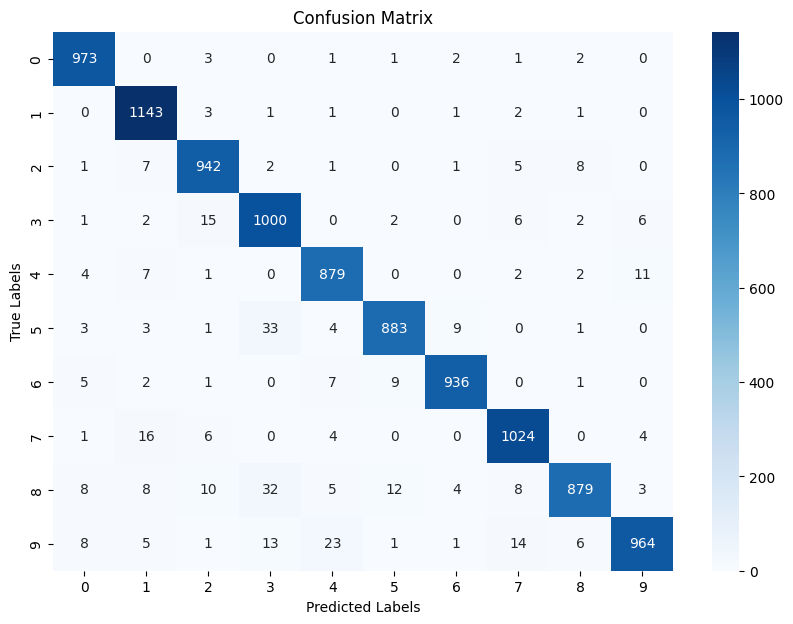

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming hard_voting_ensemble is already trained and X_test, y_test are defined

# Make predictions on the test set
test_predict = hard_voting_ensemble.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, test_predict)
precision = precision_score(y_test, test_predict, average='macro')  # Use 'micro', 'macro', 'weighted' or None based on your problem
recall = recall_score(y_test, test_predict, average='macro')
f1 = f1_score(y_test, test_predict, average='macro')

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, test_predict)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))  # Adjust labels if necessary
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.982
Precision: 0.981860274407181
Recall: 0.9819186948568109
F1 Score: 0.9818657208969637


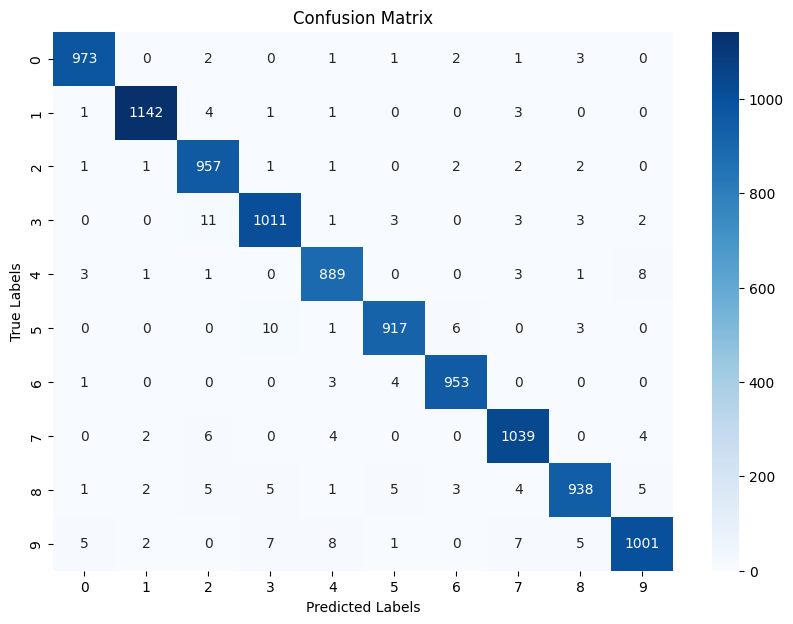

In [30]:
# Make predictions on the test set
test_predict = svm_clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, test_predict)
precision = precision_score(y_test, test_predict, average='macro')  # Use 'micro', 'macro', 'weighted' or None based on your problem
recall = recall_score(y_test, test_predict, average='macro')
f1 = f1_score(y_test, test_predict, average='macro')

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, test_predict)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))  # Adjust labels if necessary
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
from joblib import dump

dump(hard_voting_ensemble, '/home/thor_01/Documents/EC/ensemble-learning-sklearn/models_archive/hard_voting_ensemble.joblib')

['/home/thor_01/Documents/EC/ensemble-learning-sklearn/trained_models/hard_voting_ensemble.joblib']

In [28]:
from joblib import dump
dump(svm_clf, '/home/thor_01/Documents/EC/ensemble-learning-sklearn/models_archive/svm_clf.joblib')
dump(knn_pipe, '/home/thor_01/Documents/EC/ensemble-learning-sklearn/models_archive/knn_pipe.joblib')

['/home/thor_01/Documents/EC/ensemble-learning-sklearn/trained_models/knn_pipe.joblib']

In [33]:
# Using stacking 
from sklearn.ensemble import StackingClassifier

# Define base models
base_models = [
    ("random_forest", rf_pipe),
    ("extra_trees", et_pipe),
    ("svm", svm_clf),
    ("knn", knn_pipe)
]

# Define the final estimator (meta-learner)
final_estimator = LogisticRegression()

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=final_estimator)
# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

[LibSVM]*
optimization finished, #iter = 475
obj = -53.497168, rho = -0.445610
nSV = 196, nBSV = 0
.*
optimization finished, #iter = 1681
obj = -210.187908, rho = 0.205090
nSV = 620, nBSV = 0
*.*
optimization finished, #iter = 1379
obj = -142.594028, rho = 0.109837
nSV = 536, nBSV = 0
*.*
optimization finished, #iter = 1122
obj = -109.115849, rho = -0.182688
nSV = 438, nBSV = 0
.*
optimization finished, #iter = 1833
obj = -225.954762, rho = 0.241349
nSV = 645, nBSV = 0
.*
optimization finished, #iter = 1662
obj = -242.812859, rho = -0.109713
nSV = 530, nBSV = 0
*
optimization finished, #iter = 992
obj = -110.456059, rho = -0.035110
nSV = 378, nBSV = 0
.*
optimization finished, #iter = 1545
obj = -174.030161, rho = -0.142972
nSV = 582, nBSV = 0
*.*
optimization finished, #iter = 1302
obj = -161.444954, rho = -0.033127
nSV = 490, nBSV = 0
*.*
optimization finished, #iter = 1318
obj = -205.932262, rho = 0.784634
nSV = 380, nBSV = 0
*.*
optimization finished, #iter = 1211
obj = -171.974734

/home/thor_01/miniconda3/envs/ds2023/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('random_forest',
                                Pipeline(steps=[('pca', PCA(n_components=0.95)),
                                                ('random_forest',
                                                 RandomForestClassifier(max_depth=15,
                                                                        n_estimators=50,
                                                                        n_jobs=14))])),
                               ('extra_trees',
                                Pipeline(steps=[('pca', PCA(n_components=0.95)),
                                                ('extra_trees',
                                                 ExtraTreesClassifier(max_depth=15,
                                                                      n_estimators=50,
                                                                      n_jobs=14))])),
                               ('svm',
                                Pipeline(steps=[('pca', PCA(n_components=0.95)),
                                                ('svc',
                                                 SVC(C=10, verbose=2))])),
                               ('knn',
                                Pipeline(steps=[('pca', PCA(n_components=0.95)),
                                                ('knn',
                                                 KNeighborsClassifier(algorithm='ball_tree',
                                                                      n_jobs=14))]))],
                   final_estimator=LogisticRegression())

Accuracy: 0.9808
Precision: 0.9807519941236933
Recall: 0.9807546232761928
F1 Score: 0.9807402720091009


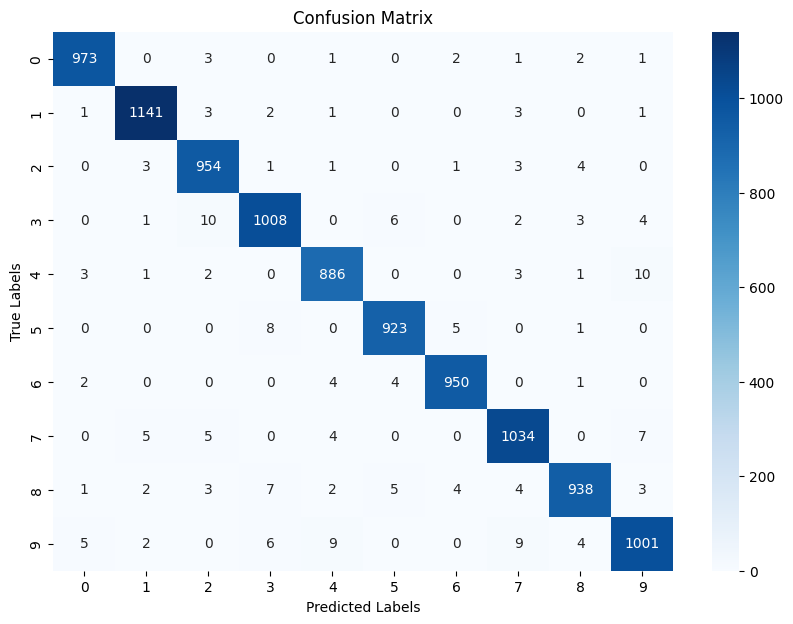

In [34]:
# Make predictions on the test set
test_predict = stacking_clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, test_predict)
precision = precision_score(y_test, test_predict, average='macro')  # Use 'micro', 'macro', 'weighted' or None based on your problem
recall = recall_score(y_test, test_predict, average='macro')
f1 = f1_score(y_test, test_predict, average='macro')

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, test_predict)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))  # Adjust labels if necessary
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Grid Search

In [12]:
# Combine X_train and X_val
X_train_val_combined = np.concatenate((X_train, X_val), axis=0)

# Combine y_train and y_val
y_train_val_combined = np.concatenate((y_train, y_val), axis=0)

# Updating models_params to include k-NN
models_params = [
    (RandomForestClassifier(n_jobs=14), {
        'n_estimators': [100, 200],
        'max_depth': [None, 30, 50],
        'min_samples_split': [2, 5],
    }),
    
    (ExtraTreesClassifier(n_jobs=14), {
        'n_estimators': [100, 200],
        'max_depth': [None, 30, 50],
        'min_samples_split': [2, 5],
    }),

    (Pipeline([
        ("standarize", StandardScaler()),
        ("svc", SVC(verbose=2, gamma="scale"))
    ]), {
        'svc__C': [1, 10, 20],
        'svc__kernel': ['rbf'],
    }),

    (KNeighborsClassifier(n_jobs=14), {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
})  
]

# Perform grid search for each model
for model, params in models_params:
    grid_search = GridSearchCV(model, params, cv=3, scoring='accuracy', verbose=2)
    grid_search.fit(X_train_val_combined, y_train_val_combined)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best score for {model.__class__.__name__}: {grid_search.best_score_}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END max_depth=None, m

Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best score for RandomForestClassifier: 0.9672833333333334
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters for ExtraTreesClassifier: {'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 200}
Best score for ExtraTreesClassifier: 0.97125
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best parameters for Pipeline: {'svc__C': 10, 'svc__kernel': 'rbf'}
Best score for Pipeline: 0.9682166666666667

Best parameters for KNeighborsClassifier: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'distance'}
Best score for KNeighborsClassifier: 0.9702166666666666

# Training final model on all data

In [22]:
# grid search final estimator

# Define base models
base_models = [
    ("random_forest", rf_clf),
    ("extra_trees", et_clf),
    ("svm", svm_clf),
    ("knn", knn_clf)
]

# Define the final estimator (meta-learner)
final_estimator = LogisticRegression(max_iter=1000)

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=final_estimator)
# Train the stacking classifier
stacking_clf.fit(X, y)

[LibSVM]*
optimization finished, #iter = 830
obj = -138.974264, rho = -0.157488
nSV = 328, nBSV = 1
..*
optimization finished, #iter = 2971
obj = -450.250991, rho = 0.674339
nSV = 1139, nBSV = 1
.*.*
optimization finished, #iter = 2524
obj = -330.848976, rho = 0.515880
nSV = 944, nBSV = 0
.*
optimization finished, #iter = 1682
obj = -227.305066, rho = 0.315899
nSV = 702, nBSV = 0
.*.*
optimization finished, #iter = 2926
obj = -467.998095, rho = 0.410332
nSV = 986, nBSV = 0
..*.*
optimization finished, #iter = 3157
obj = -547.984751, rho = 0.603567
nSV = 1087, nBSV = 5
.*.*
optimization finished, #iter = 2101
obj = -243.858670, rho = 0.670605
nSV = 938, nBSV = 0
.*.*
optimization finished, #iter = 2516
obj = -472.765858, rho = 0.235852
nSV = 857, nBSV = 4
.*.*
optimization finished, #iter = 2215
obj = -359.378512, rho = 0.378173
nSV = 770, nBSV = 1
.*.*
optimization finished, #iter = 2737
obj = -548.478855, rho = 0.752714
nSV = 940, nBSV = 8
.*.*
optimization finished, #iter = 2372
obj 

/home/thor_01/miniconda3/envs/ds2023/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('random_forest',
                                RandomForestClassifier(n_estimators=200,
                                                       n_jobs=14)),
                               ('extra_trees',
                                ExtraTreesClassifier(max_depth=50,
                                                     n_estimators=200,
                                                     n_jobs=14)),
                               ('svm',
                                Pipeline(steps=[('standarize',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(C=10, verbose=2))])),
                               ('knn',
                                KNeighborsClassifier(algorithm='ball_tree',
                                                     n_jobs=14, n_neighbors=3,
                                                     weights='distance'))],
                   final_estimator=LogisticRegression(max_iter=1000))

In [24]:
from joblib import dump

dump(stacking_clf, '/home/thor_01/Documents/EC/ensemble-learning-sklearn/trained_models/stacking_clf.joblib')

['/home/thor_01/Documents/EC/ensemble-learning-sklearn/trained_models/stacking_clf.joblib']

In [37]:
# SVC Pipeline (already has feature scaling, so just add PCA before SVC)
svm_clf_final = Pipeline([
    ("pca", pca),  # Insert PCA after standardization but before SVC
    ("svc", SVC(C=10, kernel='rbf', verbose=1, gamma="scale",probability=True))
])

svm_clf_final.fit(X,y)


dump(svm_clf_final, '/home/thor_01/Documents/EC/ensemble-learning-sklearn/trained_models/svm_clf_final.joblib')

[LibSVM]*
optimization finished, #iter = 491
obj = -61.221919, rho = 0.364046
nSV = 200, nBSV = 0
Total nSV = 200
*
optimization finished, #iter = 522
obj = -60.196523, rho = 0.351923
nSV = 211, nBSV = 0
Total nSV = 211
*
optimization finished, #iter = 526
obj = -53.697124, rho = 0.359125
nSV = 214, nBSV = 0
Total nSV = 214
*
optimization finished, #iter = 498
obj = -55.143121, rho = 0.405924
nSV = 208, nBSV = 0
Total nSV = 208
*
optimization finished, #iter = 522
obj = -56.282521, rho = 0.439858
nSV = 212, nBSV = 0
Total nSV = 212
*
optimization finished, #iter = 574
obj = -65.364812, rho = -0.360853
nSV = 225, nBSV = 0
.*
optimization finished, #iter = 1840
obj = -230.263576, rho = -0.242939
nSV = 649, nBSV = 0
Total nSV = 649
.*
optimization finished, #iter = 1709
obj = -203.487796, rho = -0.243152
nSV = 614, nBSV = 0
Total nSV = 614
.*
optimization finished, #iter = 1770
obj = -216.236655, rho = -0.271227
nSV = 650, nBSV = 0
Total nSV = 650
.*
optimization finished, #iter = 1790
ob

['/home/thor_01/Documents/EC/ensemble-learning-sklearn/trained_models/svm_clf_final.joblib']

# Adding augmentation 

In [42]:
import cv2
import numpy as np
from scipy.ndimage import rotate

def thin_out_digits(image, iterations=1):
    """
    Thins out the digits in a given MNIST image using erosion.

    Parameters:
    image (numpy.ndarray): The input image containing a digit.
    iterations (int): Number of times the erosion operation is applied.

    Returns:
    numpy.ndarray: The image with thinned digits.
    """
    # Define the erosion kernel size
    # A 3x3 kernel of ones is commonly used, but you might adjust based on your specific needs
    kernel = np.ones((3,3), np.uint8)
    
    # Apply the erosion operation
    thinned_image = cv2.erode(image, kernel, iterations=iterations)
    
    return thinned_image

def augment_dataset(X, y, augmentation_factor=0.15, rotation_degrees=10):
    num_images = len(X)
    num_augment = int(num_images * augmentation_factor)

    # Indices of images to augment
    indices_to_augment = np.random.choice(num_images, num_augment, replace=False)

    augmented_images = []
    augmented_labels = []

    for index in indices_to_augment:
        image = X[index].reshape(28, 28)  # Reshape flattened image back to 2D for processing
        label = y[index]

        # Apply thinning
        thinned_image = thin_out_digits(image)

        # Apply rotation
        rotated_image = rotate(thinned_image, angle=np.random.uniform(-rotation_degrees, rotation_degrees), reshape=False, mode='nearest')

        # Flatten the rotated image back into 1D array
        flattened_rotated_image = rotated_image.flatten()

        augmented_images.append(flattened_rotated_image)
        augmented_labels.append(label)

    # Convert lists to NumPy arrays
    augmented_images = np.array(augmented_images, dtype=X.dtype)
    augmented_labels = np.array(augmented_labels, dtype=y.dtype)

    # Append the augmented data to the original dataset
    X_augmented = np.concatenate((X, augmented_images), axis=0)
    y_augmented = np.concatenate((y, augmented_labels), axis=0)

    return X_augmented, y_augmented

# Assuming X_train and y_train are your original MNIST dataset and labels
# Apply augmentation to increase dataset size by 15% with thinning and rotation
X_train_augmented, y_train_augmented = augment_dataset(X, y, augmentation_factor=0.30, rotation_degrees=3)

print(X_train_augmented.shape, y_train_augmented.shape)

# Example usage (Note: X_train and y_train should be defined in your actual use case)
# X_train_augmented, y_train_augmented = augment_dataset(X_train, y_train, augmentation_factor=0.15, rotation_degrees=10)

(91000, 784) (91000,)


In [43]:
# SVC Pipeline (already has feature scaling, so just add PCA before SVC)
svm_clf_final = Pipeline([
    ("pca", pca),  # Insert PCA after standardization but before SVC
    ("svc", SVC(C=10, kernel='rbf', verbose=1, gamma="scale",probability=True))
])

svm_clf_final.fit(X_train_augmented,y_train_augmented)


dump(svm_clf_final, '/home/thor_01/Documents/EC/ensemble-learning-sklearn/trained_models/svm_clf_final_augmented_2.joblib')

[LibSVM]*
optimization finished, #iter = 786
obj = -2285.104112, rho = -0.371857
nSV = 442, nBSV = 272
Total nSV = 442
*
optimization finished, #iter = 678
obj = -2331.867570, rho = -0.433295
nSV = 449, nBSV = 288
Total nSV = 449
*
optimization finished, #iter = 728
obj = -2387.293126, rho = -0.439638
nSV = 453, nBSV = 290
Total nSV = 453
*
optimization finished, #iter = 722
obj = -2343.487469, rho = -0.326075
nSV = 450, nBSV = 286
Total nSV = 450
*
optimization finished, #iter = 651
obj = -2279.216803, rho = -0.425710
nSV = 427, nBSV = 282
Total nSV = 427
*
optimization finished, #iter = 860
obj = -2753.959302, rho = 0.452092
nSV = 507, nBSV = 336
.*.*
optimization finished, #iter = 2452
obj = -3902.232759, rho = -0.523987
nSV = 986, nBSV = 436
Total nSV = 986
.*.*
optimization finished, #iter = 2202
obj = -3896.832043, rho = -0.459050
nSV = 949, nBSV = 430
Total nSV = 949
.*.*
optimization finished, #iter = 2382
obj = -3999.703762, rho = -0.448180
nSV = 997, nBSV = 443
Total nSV = 99

['/home/thor_01/Documents/EC/ensemble-learning-sklearn/trained_models/svm_clf_final_augmented_2.joblib']